#  Evaluating the sensitivity of recall to different splits

One aspect of the challenge of classifying XBT instrument types that was identified quite early was the importance of how the data is split into test/train/dev sets, given the type imbalances and the changes in type distributuions on the time period of the dataset. Degradation of recall values when doing hyperparameter tuning with cross-validation compared to just cross-validation was eventually tracked down to using the wrong sort of split for the inner cross-validation in the hyperparameter, which emphasises again the sensitivity of the data to the split used. This notebook attempts to do some basic quantification of the change in recall on the unseen (test) data for different choices of split when doing cross-validation. The different sorts of split demomstrated here are:
* `split_by_cruise` split by cruise - this divides each year into cruises and puts whole cruises into different folds
* `split_random_with_shuffle` splitting with shuffle - this does random splitting into folds, by doing an initial random shuffling
* `split_random_no_shuffle` consecutive selection - this just divides up the data into folds consecutively without shuffling
* `split_stratified_with_shuffle` stratified folds - this attempts to keep similar distribution of instrument type in different folds compared to the whole dataset, with initial random shuffling
* `split_stratified_no_shuffle` stratified folds no shuffling - this attempts to keep similar distribution of instrument type in different folds compared to the whole dataset, with no initial shuffling

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import pathlib
import random

In [2]:
import ipywidgets
import time

In [3]:
import pandas
import numpy
import matplotlib
import matplotlib.pyplot

In [4]:
import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.tree
import sklearn.metrics

In [5]:
root_repo_dir = pathlib.Path().absolute().parent
sys.path = [os.path.join(root_repo_dir)] + sys.path

In [6]:
import xbt.dataset
from xbt.dataset import XbtDataset, UNKNOWN_STR, cat_output_formatter, check_value_found
from xbt.imeta import imeta_classification, XBT_MAX_DEPTH

In [7]:
# Set up some site specific parameters for the notebook
try:
    environment = os.environ['XBT_ENV_NAME']
except KeyError:
    environment = 'pangeo'

In [8]:
root_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/',
    'pangeo': '/data/misc/xbt-data/',
}
env_date_ranges = {
    'MO_scitools': (1966,2015),
    'pangeo': (1966,2015)
}

### Define experiment parameters
These are some key hyperparameters we're using for this experiment, such as input features and number of splits, and the hyperparameter fed to the tree object, such as max depth.

In [9]:
experiment_name = 'nb_decisionTree_cv_noHPT_country'

classifier_class = sklearn.tree.DecisionTreeClassifier
classifier_opts = {}
classifier_name = 'decision_tree_cv'
suffix='country'
classifier_opts = {
    'max_depth': 20, 
    'min_samples_leaf': 1, 
    'criterion': 'gini',
}
cv_metrics = ['recall_micro', 'precision_micro', 'f1_micro']
hp_tune_metric = 'recall_micro'

In [10]:
input_feature_names = ['max_depth', 'year', 'lat', 'lon', 'country']
target_feature = 'instrument'
splitter_features = ['year', 'instrument']
unseen_feature = 'cruise_number'
ensemble_unseen_fraction = 0.1
num_unseen_splits = 5
unseen_fraction = 1.0 / num_unseen_splits
num_train_splits = 5
train_fraction = 1.0 - (1.0 / num_train_splits)
unseen_fold_name = 'unseen_fold'

In [11]:
# Set up some dataset specific parameters
root_data_dir = root_data_dirs[environment]
year_range = env_date_ranges[environment]

In [12]:
input_dir_name = 'csv_with_imeta'
exp_out_dir_name = 'nb_outputs'

In [13]:
xbt_input_dir = os.path.join(root_data_dir, input_dir_name)
xbt_output_dir = os.path.join(root_data_dir, exp_out_dir_name, experiment_name)

In [14]:
# create the output for this experiment if it doesn't exist
if not os.path.isdir(xbt_output_dir):
    os.makedirs(xbt_output_dir)
print(f'outputting to {xbt_output_dir}')

outputting to /data/users/shaddad/xbt-data/nb_outputs/nb_decisionTree_cv_noHPT_country


In [15]:
output_fname_template = 'xbt_output_{classifier}_{suffix}.csv'
result_fname_template = 'xbt_metrics_{classifier}_{suffix}.csv'

## Running the cross validation experiment

There are multiple levels to the experiment we want to run. The first to train on part of the data and then test on another part. We want to divide up the profiles by cruise, so the test data consists of cruises that were not seen in the training data. We then want to train a model for each of the possible train/test splits. We divide the model into "folds", and then each splits uses data in fold n as the test set and ther rest as the train, as is standard in machine learning. 

In this case calculate the fold labels manually rather than using standard functions so we can divide based on cruise number and assign profiles to a fold based on which cruise they come from. This is based on the analysis in the data exploration notebook, which shows that some unlabelled profiles come from cruises with no labelled profiles. We want to check that our algorithm will generalise well to such profiles, so we simulate this in the labelled data by setting aside whole cruises to not be used in training but rather in final evaluation.


We train one algorithm for each fold in the cross validation, which is the same process process as in the first notebook without cross-validation.

More information on the approach taken here and the spceific classes and function used can found in the following links:

scikit-learn API documentation:
* https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

discussion of cross-validationand hyperparameters for decision trees:
* https://scikit-learn.org/stable/modules/cross_validation.html
* https://stackoverflow.com/questions/60996995/use-groupkfold-in-nested-cross-validation-using-sklearn
* https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
* https://scikit-learn.org/stable/modules/tree.html


In [16]:
%%time
xbt_full_dataset = XbtDataset(xbt_input_dir, year_range)

CPU times: user 51.1 s, sys: 15.1 s, total: 1min 6s
Wall time: 1min 17s


In [17]:
%%time
xbt_labelled = xbt_full_dataset.filter_obs({'labelled': 'labelled'})

CPU times: user 223 ms, sys: 67.4 ms, total: 291 ms
Wall time: 289 ms


In [18]:
_ = xbt_labelled.get_ml_dataset(return_data=False)

In [19]:
_ = xbt_labelled.filter_features(xbt.dataset.TARGET_FEATURES).encode_target(return_data = False)

### Outer split for ensemble testing
As part of this experiment, we will be combining the classifiers on trained each of the splits by using the output of each as avote, and then calculating a pseudo-probability based on the voting. In order to compare the performance of the ensemble voting classifier results with individual classifiers, we need some data that has not been used to train the ensemble. Each individual classifier created excludes a fold of the data for testing by default as part of cross-validation, which is good ML practice. But when all the classifiers are combined, the ensemble has been trained on all the data presented to the cross-validation algorithm, so we need a separate test set for evaluating the metrics of the ensemble classifier. So as for inside cross-validation, we will select some cruises which we hold back and then use at the end for evaluation.

In [20]:
# ensemble_unseen_cruise_numbers = xbt_labelled.sample_feature_values(unseen_feature, fraction=ensemble_unseen_fraction, split_feature='year')    
ensemble_unseen_cruise_numbers = xbt_labelled.sample_feature_values(unseen_feature, fraction=ensemble_unseen_fraction)    
xbt_ens_unseen = xbt_labelled.filter_obs({unseen_feature: ensemble_unseen_cruise_numbers}, mode='include', check_type='in_filter_set')
xbt_ens_working = xbt_labelled.filter_obs({unseen_feature: ensemble_unseen_cruise_numbers}, mode='exclude', check_type='in_filter_set')

In [21]:
%%time
#TODO: ensure split is even by year and instrument
# this can be done by selecting each year in turn, getting the cruises for that year, then randomising th e list using random.shuffle 
# and selecting the first n items, where n = m *(1 /f) where m is total items in the year and f is the number of splits
xbt_ens_working.generate_folds_by_feature('cruise_number', num_unseen_splits, unseen_fold_name)

CPU times: user 28.5 s, sys: 55.6 ms, total: 28.6 s
Wall time: 28.6 s


In [22]:
X_labelled = xbt_ens_working.filter_features(input_feature_names).get_ml_dataset()[0]
y_labelled = xbt_ens_working.filter_features([target_feature]).get_ml_dataset()[0]


## Running different splits

We would like to compare the results we get for the unseen data, which is excluded from the CV/HPT process) for different splits of the data for cross-validation and hyperparameter tuning. Different ways of splitting could include:

* random splitting
* splitting by cruise number
* stratified splitting
* hyperparameter tuning with cruise-based split for outer CV and random inner split.
* shuffling turned off or on


In [23]:
scores_dict = {}

### Splitting by cruise

In [24]:
%%time
scores_dict['split_by_cruise'] = sklearn.model_selection.cross_validate(
    classifier_class(**classifier_opts),
    X_labelled, y_labelled, 
    groups=xbt_ens_working[unseen_fold_name], 
    cv=sklearn.model_selection.GroupKFold(n_splits=num_unseen_splits),
    return_estimator=True,
    return_train_score=True,
    scoring=cv_metrics,
    n_jobs=-1,
)

CPU times: user 274 ms, sys: 503 ms, total: 778 ms
Wall time: 41.5 s


### Random splitting with pre-shuffling

In [25]:
%%time
scores_dict['split_random_with_shuffle'] = sklearn.model_selection.cross_validate(
    classifier_class(**classifier_opts),
    X_labelled, y_labelled, 
    groups=xbt_ens_working[unseen_fold_name], 
    cv=sklearn.model_selection.KFold(n_splits=num_unseen_splits, 
                                     random_state=random.randint(1,2**20), 
                                     shuffle=True),
    return_estimator=True,
    return_train_score=True,
    scoring=cv_metrics,
    n_jobs=-1,
)

CPU times: user 247 ms, sys: 336 ms, total: 584 ms
Wall time: 37.2 s


### Random splitting without pre-shuffling

In [26]:
%%time
scores_dict['split_random_no_shuffle'] = sklearn.model_selection.cross_validate(
    classifier_class(**classifier_opts),
    X_labelled, y_labelled, 
    groups=xbt_ens_working[unseen_fold_name], 
    cv=sklearn.model_selection.KFold(n_splits=num_unseen_splits, 
                                     shuffle=False),
    return_estimator=True,
    return_train_score=True,
    scoring=cv_metrics,
    n_jobs=-1,
)

CPU times: user 138 ms, sys: 286 ms, total: 424 ms
Wall time: 38.1 s


### Stratified Splitting

In [27]:
%%time
scores_dict['split_stratified__with_shuffle'] = sklearn.model_selection.cross_validate(
    classifier_class(**classifier_opts),
    X_labelled, y_labelled, 
    groups=xbt_ens_working[unseen_fold_name], 
    cv=sklearn.model_selection.StratifiedKFold(n_splits=num_unseen_splits, 
                                               shuffle=True, 
                                               random_state=random.randint(1,2**20)),
    return_estimator=True,
    return_train_score=True,
    scoring=cv_metrics,
    n_jobs=-1,
)

CPU times: user 330 ms, sys: 344 ms, total: 674 ms
Wall time: 38.2 s


In [28]:
%%time
scores_dict['split_stratified_no_shuffle'] = sklearn.model_selection.cross_validate(
    classifier_class(**classifier_opts),
    X_labelled, y_labelled, 
    groups=xbt_ens_working[unseen_fold_name], 
    cv=sklearn.model_selection.StratifiedKFold(n_splits=num_unseen_splits, 
                                               shuffle=False,
                                              ),
    return_estimator=True,
    return_train_score=True,
    scoring=cv_metrics,
    n_jobs=-1,
)

CPU times: user 283 ms, sys: 285 ms, total: 568 ms
Wall time: 36.6 s


### Initial results

Looking at the train and test scores reported by the cross-validatiom can give us an initial idea of the relative results. 

In [29]:
scores_dict.keys()

dict_keys(['split_by_cruise', 'split_random_with_shuffle', 'split_random_no_shuffle', 'split_stratified__with_shuffle', 'split_stratified_no_shuffle'])

In [30]:
scores_dict['split_by_cruise']

{'fit_time': array([19.52016807, 20.18903232, 20.65796828, 20.95518565, 13.42077971]),
 'score_time': array([0.43834496, 0.38101411, 0.3775456 , 0.3980341 , 0.29092646]),
 'estimator': (DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20)),
 'test_recall_micro': array([0.84725263, 0.93440213, 0.92977974, 0.9263169 , 0.92833925]),
 'train_recall_micro': array([0.97955087, 0.97469658, 0.97260448, 0.97353638, 0.97399518]),
 'test_precision_micro': array([0.84725263, 0.93440213, 0.92977974, 0.9263169 , 0.92833925]),
 'train_precision_micro': array([0.97955087, 0.97469658, 0.97260448, 0.97353638, 0.97399518]),
 'test_f1_micro': array([0.84725263, 0.93440213, 0.92977974, 0.9263169 , 0.92833925]),
 'train_f1_micro': array([0.97955087, 0.97469658, 0.97260448, 0.97353638, 0.97399518])}

In [31]:
scores_dict['split_random_with_shuffle']

{'fit_time': array([20.97846603, 22.01756716, 20.92067599, 21.77076745, 12.27081728]),
 'score_time': array([0.4126637 , 0.50639009, 0.37859297, 0.39065647, 0.24661088]),
 'estimator': (DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20)),
 'test_recall_micro': array([0.95508513, 0.95671054, 0.95691918, 0.95591482, 0.95623505]),
 'train_recall_micro': array([0.97284341, 0.97436451, 0.9737665 , 0.97396301, 0.97422744]),
 'test_precision_micro': array([0.95508513, 0.95671054, 0.95691918, 0.95591482, 0.95623505]),
 'train_precision_micro': array([0.97284341, 0.97436451, 0.9737665 , 0.97396301, 0.97422744]),
 'test_f1_micro': array([0.95508513, 0.95671054, 0.95691918, 0.95591482, 0.95623505]),
 'train_f1_micro': array([0.97284341, 0.97436451, 0.9737665 , 0.97396301, 0.97422744])}

In [32]:
scores_dict['split_random_no_shuffle']

{'fit_time': array([20.38707232, 20.26405954, 20.36315656, 20.42166281, 13.40789676]),
 'score_time': array([0.36401224, 0.37674427, 0.42372894, 0.42872906, 0.34262085]),
 'estimator': (DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20)),
 'test_recall_micro': array([0.9124798 , 0.90904459, 0.70929302, 0.77118015, 0.75076783]),
 'train_recall_micro': array([0.97018088, 0.97118888, 0.98074245, 0.98266627, 0.97495645]),
 'test_precision_micro': array([0.9124798 , 0.90904459, 0.70929302, 0.77118015, 0.75076783]),
 'train_precision_micro': array([0.97018088, 0.97118888, 0.98074245, 0.98266627, 0.97495645]),
 'test_f1_micro': array([0.9124798 , 0.90904459, 0.70929302, 0.77118015, 0.75076783]),
 'train_f1_micro': array([0.97018088, 0.97118888, 0.98074245, 0.98266627, 0.97495645])}

In [33]:
scores_dict['split_stratified__with_shuffle']

{'fit_time': array([22.08968282, 21.23818088, 21.16921067, 22.06717181, 12.68648672]),
 'score_time': array([0.52443504, 0.39245439, 0.4027195 , 0.39983749, 0.28473377]),
 'estimator': (DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20)),
 'test_recall_micro': array([0.95653102, 0.95702107, 0.95562855, 0.95656984, 0.95574015]),
 'train_recall_micro': array([0.9734863 , 0.97364278, 0.9739157 , 0.97429052, 0.97362216]),
 'test_precision_micro': array([0.95653102, 0.95702107, 0.95562855, 0.95656984, 0.95574015]),
 'train_precision_micro': array([0.9734863 , 0.97364278, 0.9739157 , 0.97429052, 0.97362216]),
 'test_f1_micro': array([0.95653102, 0.95702107, 0.95562855, 0.95656984, 0.95574015]),
 'train_f1_micro': array([0.9734863 , 0.97364278, 0.9739157 , 0.97429052, 0.97362216])}

In [34]:
scores_dict['split_stratified_no_shuffle']

{'fit_time': array([19.63685036, 18.97008419, 20.17553139, 20.50342965, 13.60962987]),
 'score_time': array([0.44438887, 0.3546598 , 0.47741842, 0.36518669, 0.24443793]),
 'estimator': (DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20),
  DecisionTreeClassifier(max_depth=20)),
 'test_recall_micro': array([0.4587314 , 0.35152183, 0.58078806, 0.5711423 , 0.07780651]),
 'train_recall_micro': array([0.98377009, 0.98177471, 0.97214473, 0.98369367, 0.97476844]),
 'test_precision_micro': array([0.4587314 , 0.35152183, 0.58078806, 0.5711423 , 0.07780651]),
 'train_precision_micro': array([0.98377009, 0.98177471, 0.97214473, 0.98369367, 0.97476844]),
 'test_f1_micro': array([0.4587314 , 0.35152183, 0.58078806, 0.5711423 , 0.07780651]),
 'train_f1_micro': array([0.98377009, 0.98177471, 0.97214473, 0.98369367, 0.97476844])}

## Generate probabilities and evaluate

As we have trained multiple algorithms, one for each split, we can combine the results using the output from each as a vote. We can then find the ensemble classifaication by choosing the probe type with the most votes. This can be formulated as a pseudo probability, by adding up number of votes and dividing by the number of classifiers so the values sum to one. This gives an idea of uncertainty. Where all classifiers agree and the probability is 1, then we are confident in the classification. Where the probability is less than one, classifiers do not all agree and we are less certain.


In [35]:
result_feature_template = 'instrument_res_dt_split{split_num}'

In [36]:
%%time
df_ens_working_dict = {}
df_ens_unseen_dict = {}
vote_count_working_dict = {}
vote_count_unseen_dict = {} 
result_feature_names_dict = {}
for fold_type, scores in scores_dict.items():
    res_ens_working = {'id': xbt_ens_working.xbt_df['id']}
    res_ens_unseen = {'id': xbt_ens_unseen.xbt_df['id']}
    vote_count_working_dict[fold_type] = numpy.zeros([xbt_ens_working.shape[0], xbt_labelled._feature_encoders[target_feature].classes_.shape[0]],dtype=numpy.float64)
    vote_count_unseen_dict[fold_type] = numpy.zeros([xbt_ens_unseen.shape[0], xbt_labelled._feature_encoders[target_feature].classes_.shape[0]],dtype=numpy.float64)
    result_feature_names_dict[fold_type] = []
    # classifications_df = None
    for split_num, estimator in enumerate(scores['estimator']):
        res_name = result_feature_template.format(split_num=split_num)
        result_feature_names_dict[fold_type] += [res_name]
        res_ml1_working = estimator.predict(xbt_ens_working.filter_features(input_feature_names).get_ml_dataset()[0])
        res2_working = xbt_ens_working._feature_encoders[target_feature].inverse_transform(res_ml1_working).reshape(-1,1)
        res_ens_working[res_name] = res2_working.reshape(-1)
        vote_count_working_dict[fold_type] += xbt_ens_working._target_encoders[target_feature].transform(res2_working)

        res_ml1_unseen = estimator.predict(xbt_ens_unseen.filter_features(input_feature_names).get_ml_dataset()[0])
        res2_unseen = xbt_ens_unseen._feature_encoders[target_feature].inverse_transform(res_ml1_unseen).reshape(-1,1)
        res_ens_unseen[res_name] = res2_unseen.reshape(-1)
        vote_count_unseen_dict[fold_type] += xbt_ens_unseen._target_encoders[target_feature].transform(res2_unseen)

    df_ens_working_dict[fold_type] = pandas.DataFrame(res_ens_working)
    df_ens_unseen_dict[fold_type] = pandas.DataFrame(res_ens_unseen)

    vote_count_working_dict[fold_type] /= float(len(res_ens_working.keys()))    
    vote_count_unseen_dict[fold_type] /= float(len(res_ens_working.keys()))    
scores = None

CPU times: user 27.2 s, sys: 22.1 s, total: 49.3 s
Wall time: 49.3 s


In [37]:
max_prob_feature_name = f'{target_feature}_max_prob'
for fold_type in scores_dict.keys():
    res_working_ensemble = vote_count_working_dict[fold_type].argmax(axis=1)
    instr_res_working_ensemble = xbt_labelled._feature_encoders[target_feature].inverse_transform(res_working_ensemble)
    df_ens_working_dict[fold_type][max_prob_feature_name] = instr_res_working_ensemble
    res_unseen_ensemble = vote_count_unseen_dict[fold_type].argmax(axis=1)
    instr_res_unseen_ensemble = xbt_labelled._feature_encoders[target_feature].inverse_transform(res_unseen_ensemble)
    df_ens_unseen_dict[fold_type][max_prob_feature_name] = instr_res_unseen_ensemble

In [38]:
for fold_type in scores_dict.keys():
    df_ens_working_dict[fold_type] = pandas.merge(df_ens_working_dict[fold_type], xbt_ens_working.xbt_df[['id', 'year']])
    df_ens_unseen_dict[fold_type] = pandas.merge(df_ens_unseen_dict[fold_type], xbt_ens_unseen.xbt_df[['id', 'year']])

In [39]:
metrics_df_ens_dict = {}
for fold_type in scores_dict.keys():
    df_ens_working = df_ens_working_dict[fold_type]
    df_ens_unseen = df_ens_unseen_dict[fold_type]
    metric_list_ens = []
    for year in range(year_range[0],year_range[1]):
        y_ens_working = xbt_ens_working.filter_obs({'year': year} ).filter_features([target_feature]).get_ml_dataset()[0]
        y_ens_unseen = xbt_ens_unseen.filter_obs({'year': year} ).filter_features([target_feature]).get_ml_dataset()[0]
        y_res_working = xbt_ens_working._feature_encoders[target_feature].transform( df_ens_working[df_ens_working.year == year]['instrument_max_prob'])    
        y_res_unseen = xbt_ens_unseen._feature_encoders[target_feature].transform( df_ens_unseen[df_ens_unseen.year == year]['instrument_max_prob'])    
        cats = list(xbt_ens_working._feature_encoders[target_feature].classes_)
        prec_ens_working, recall_ens_working, f1_ens_working, support_ens_working = sklearn.metrics.precision_recall_fscore_support(
            y_ens_working, y_res_working, average='micro', labels=range(0,len(cats)))
        prec_ens_unseen, recall_ens_unseen, f1_ens_unseen, support_ens_unseen = sklearn.metrics.precision_recall_fscore_support(
            y_ens_unseen, y_res_unseen, average='micro', labels=range(0,len(cats)))

        column_template = '{metric}_{data}_{subset}'
        metric_dict = {'year': year,
                       column_template.format(data='ens_working', metric='precision', subset='all'): prec_ens_working,
                       column_template.format(data='ens_working', metric='recall', subset='all'): recall_ens_working,
                       column_template.format(data='ens_working', metric='f1', subset='all'): f1_ens_working,
                       column_template.format(data='ens_unseen', metric='precision', subset='all'): prec_ens_unseen,
                       column_template.format(data='ens_unseen', metric='recall', subset='all'): recall_ens_unseen,
                       column_template.format(data='ens_unseen', metric='f1', subset='all'): f1_ens_unseen,
                      }

        metric_list_ens += [metric_dict]
    metrics_df_ens_dict[fold_type] = pandas.DataFrame.from_records(metric_list_ens)    

In [40]:
cats = list(xbt_ens_working._feature_encoders[target_feature].classes_)

In [41]:
scores_ens_working = {}
scores_ens_unseen = {}

In [42]:
for fold_type in scores_dict.keys():
    y_ens_working = xbt_ens_working.filter_features([target_feature]).get_ml_dataset()[0]
    y_res_working = xbt_ens_working._feature_encoders[target_feature].transform( df_ens_working_dict[fold_type]['instrument_max_prob'])    
    prec_ens_working, recall_ens_working, f1_ens_working, support_ens_working = sklearn.metrics.precision_recall_fscore_support(
        y_ens_working, y_res_working, average='micro', labels=range(0,len(cats)))

    column_template = '{metric}_{data}_{subset}'
    scores_ens_working[fold_type] = {
        'name': 'ens_working',
        'subset': 'train',
        'precision_all': prec_ens_working,
        'recall_all': recall_ens_working,
        'f1_all': f1_ens_working,
        'support_all': support_ens_working,
    }


In [43]:
for fold_type in scores_dict.keys():
    y_ens_unseen = xbt_ens_unseen.filter_features([target_feature]).get_ml_dataset()[0]
    y_res_unseen = xbt_ens_unseen._feature_encoders[target_feature].transform( df_ens_unseen_dict[fold_type]['instrument_max_prob'])    
    prec_ens_unseen, recall_ens_unseen, f1_ens_unseen, support_ens_unseen = sklearn.metrics.precision_recall_fscore_support(
        y_ens_unseen, y_res_unseen, average='micro', labels=range(0,len(cats)))
    scores_ens_unseen[fold_type] = {
        'name': 'ens_unseen',
        'subset': 'unseen',
        'precision_all': prec_ens_unseen,
        'recall_all': recall_ens_unseen,
        'f1_all': f1_ens_unseen,
        'support_all': f1_ens_unseen,
    }


## Plotting results of cross-validation and hyperparameter tuning
In this section we will take a look at the results from the cross validation and hyperparameter tuning of the decision tree to the XBT labelled data. To gain greater understanding, we seprately score the train and test sets for each year of the data and each class of instrument label. This is calculated separately for eeach of the estimators trained for the outer cross-validation (based on cruise numbers). We calculate the recall, precision and f1 metrics both for each class and averaged over all classes.

In [44]:
def generate_metrics(clf, xbt_ds, data_label, target_feature, input_feature_names, year_range, subset):
    metric_list = []
    for year in range(year_range[0],year_range[1]):
        X_year = xbt_ds.filter_obs({'year': year}, ).filter_features(input_feature_names).get_ml_dataset()[0]
        y_year = xbt_ds.filter_obs({'year': year} ).filter_features([target_feature]).get_ml_dataset()[0]

        y_res_year = clf.predict(X_year)
        cats = list(xbt_ds._feature_encoders[target_feature].classes_)
        prec_year, recall_year, f1_year, support_year = sklearn.metrics.precision_recall_fscore_support(
            y_year, y_res_year, average='micro', labels=range(0,len(cats)))
        prec_cat, recall_cat, f1_cat, support_cat = sklearn.metrics.precision_recall_fscore_support(
            y_year, y_res_year, labels=range(0,len(cats)))

        column_template = '{metric}_{data}_{subset}'
        metric_dict = {'year': year,
                       column_template.format(data=data_label, metric='precision', subset='all'): prec_year,
                       column_template.format(data=data_label, metric='recall', subset='all'): recall_year,
                       column_template.format(data=data_label, metric='f1', subset='all'): f1_year,
                       column_template.format(data=data_label, metric='support', subset='all'): support_year,
                      }

        metric_dict.update({column_template.format(data=data_label, metric='precision', subset=cat): val for cat, val in zip(cats, prec_cat)})
        metric_dict.update({column_template.format(data=data_label, metric='recall', subset=cat): val for cat, val in zip(cats, recall_cat)})
        metric_dict.update({column_template.format(data=data_label, metric='f1', subset=cat): val for cat, val in zip(cats, f1_cat)})
        metric_dict.update({column_template.format(data=data_label, metric='support', subset=cat): val for cat, val in zip(cats, support_cat)})
        metric_list += [metric_dict]

    metrics_df = pandas.DataFrame.from_records(metric_list)
    
    X_full = xbt_ds.filter_features(input_feature_names).get_ml_dataset()[0]
    y_full = xbt_ds.filter_features([target_feature]).get_ml_dataset()[0]
    y_res_full = clf.predict(X_full)
    prec_full, recall_full, f1_full, support_full = sklearn.metrics.precision_recall_fscore_support(
            y_full, y_res_full, average='micro')
    metrics_full = {
        'name': data_label,
        'subset': subset,
        'precision_all': prec_full,
        'recall_all': recall_full,
        'f1_all': f1_full,
        'support_all': support_full,
        }    
    return metrics_df, metrics_full

In [45]:
%%time
scores_df_dict = {}
metrics_dict = {}
for fold_type, scores in scores_dict.items():
    print(f'generating scores by year for {fold_type}')
    metrics_list = {}
    scores_list = [scores_ens_working[fold_type], scores_ens_unseen[fold_type]]
    for split_num, estimator in enumerate(scores['estimator']):
        xbt_train = xbt_ens_working.filter_obs({unseen_fold_name: split_num}, mode='exclude')
        xbt_test = xbt_ens_working.filter_obs({unseen_fold_name: split_num}, mode='include')
        train_metrics, train_scores = generate_metrics(estimator, xbt_train, 'train_{0}'.format(split_num), target_feature, input_feature_names, year_range, 'train' )
        test_metrics, test_scores = generate_metrics(estimator, xbt_test, 'test_{0}'.format(split_num), target_feature, input_feature_names, year_range, 'test')
        unseen_metrics, unseen_scores = generate_metrics(estimator, xbt_ens_unseen, 'unseen_{0}'.format(split_num), target_feature, input_feature_names, year_range, 'unseen')
        scores_list += [train_scores, test_scores, unseen_scores]
        metrics_list[split_num] = pandas.merge(pandas.merge(train_metrics, test_metrics, on='year'), unseen_metrics, on='year')
    scores_df_dict[fold_type] = pandas.DataFrame.from_records(scores_list)
    metrics_dict[fold_type] = metrics_list
scores=None
fold_type=None

generating scores by year for split_by_cruise
generating scores by year for split_random_with_shuffle
generating scores by year for split_random_no_shuffle
generating scores by year for split_stratified__with_shuffle
generating scores by year for split_stratified_no_shuffle
CPU times: user 3min 27s, sys: 54.6 s, total: 4min 21s
Wall time: 4min 21s


In [79]:
d1 = {'name': scores_df_dict['split_by_cruise']['name']}
d1.update({f'recall_{k1}' : v1['recall_all'] for k1,v1 in scores_df_dict.items()})
sensitivity_summary_df = pandas.DataFrame(d1)
sensitivity_summary_df

,name,recall_split_by_cruise,recall_split_random_with_shuffle,recall_split_random_no_shuffle,recall_split_stratified__with_shuffle,recall_split_stratified_no_shuffle
0,ens_working,0.975918,0.974669,0.975628,0.974473,0.977753
1,ens_unseen,0.946977,0.942169,0.942970,0.943882,0.947115
2,train_0,0.942947,0.968280,0.957580,0.969144,0.877723
3,test_0,0.979342,0.973825,0.963393,0.974357,0.883422
4,unseen_0,0.936385,0.939065,0.931531,0.939019,0.853907
5,train_1,0.963467,0.970253,0.958167,0.969610,0.857752
6,test_1,0.979420,0.973177,0.961150,0.973177,0.847543
7,unseen_1,0.937545,0.939691,0.933401,0.940962,0.823882
8,train_2,0.961886,0.970477,0.927489,0.970436,0.894659
9,test_2,0.973379,0.970061,0.922100,0.969511,0.890577


recall_split_by_cruise                   0.938884
recall_split_random_with_shuffle         0.939088
recall_split_random_no_shuffle           0.918282
recall_split_stratified__with_shuffle    0.940172
recall_split_stratified_no_shuffle       0.858918
dtype: float64

<AxesSubplot:xlabel='name'>

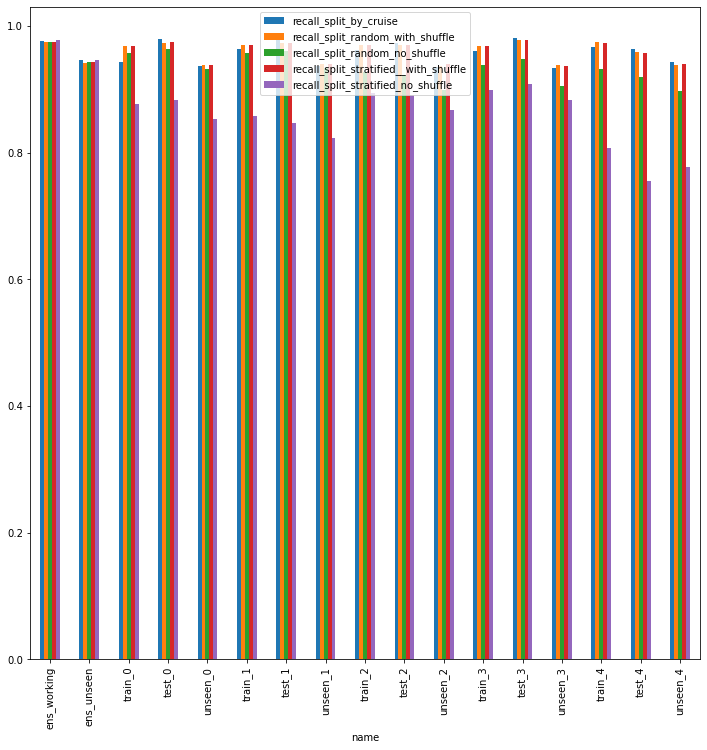

In [47]:
pandas.DataFrame(d1).plot.bar(x='name',figsize=(12,12))

In [ ]:
sn1 = 0
subset1 = 'unseen'
[v1[sn1][['year', f'recall_{subset1}_{sn1}_all']] for k1,v1 in metrics_dict.items()]

In [55]:
import functools

In [63]:
results_by_fold_subset = {fold1: {subset1: functools.reduce(pandas.merge, [metrics_dict[fold1][ix1][['year',f'recall_{subset1}_{ix1}_all']] for ix1 in range(0,5)]) for subset1 in ['train','test','unseen']} for fold1 in metrics_dict.keys()}

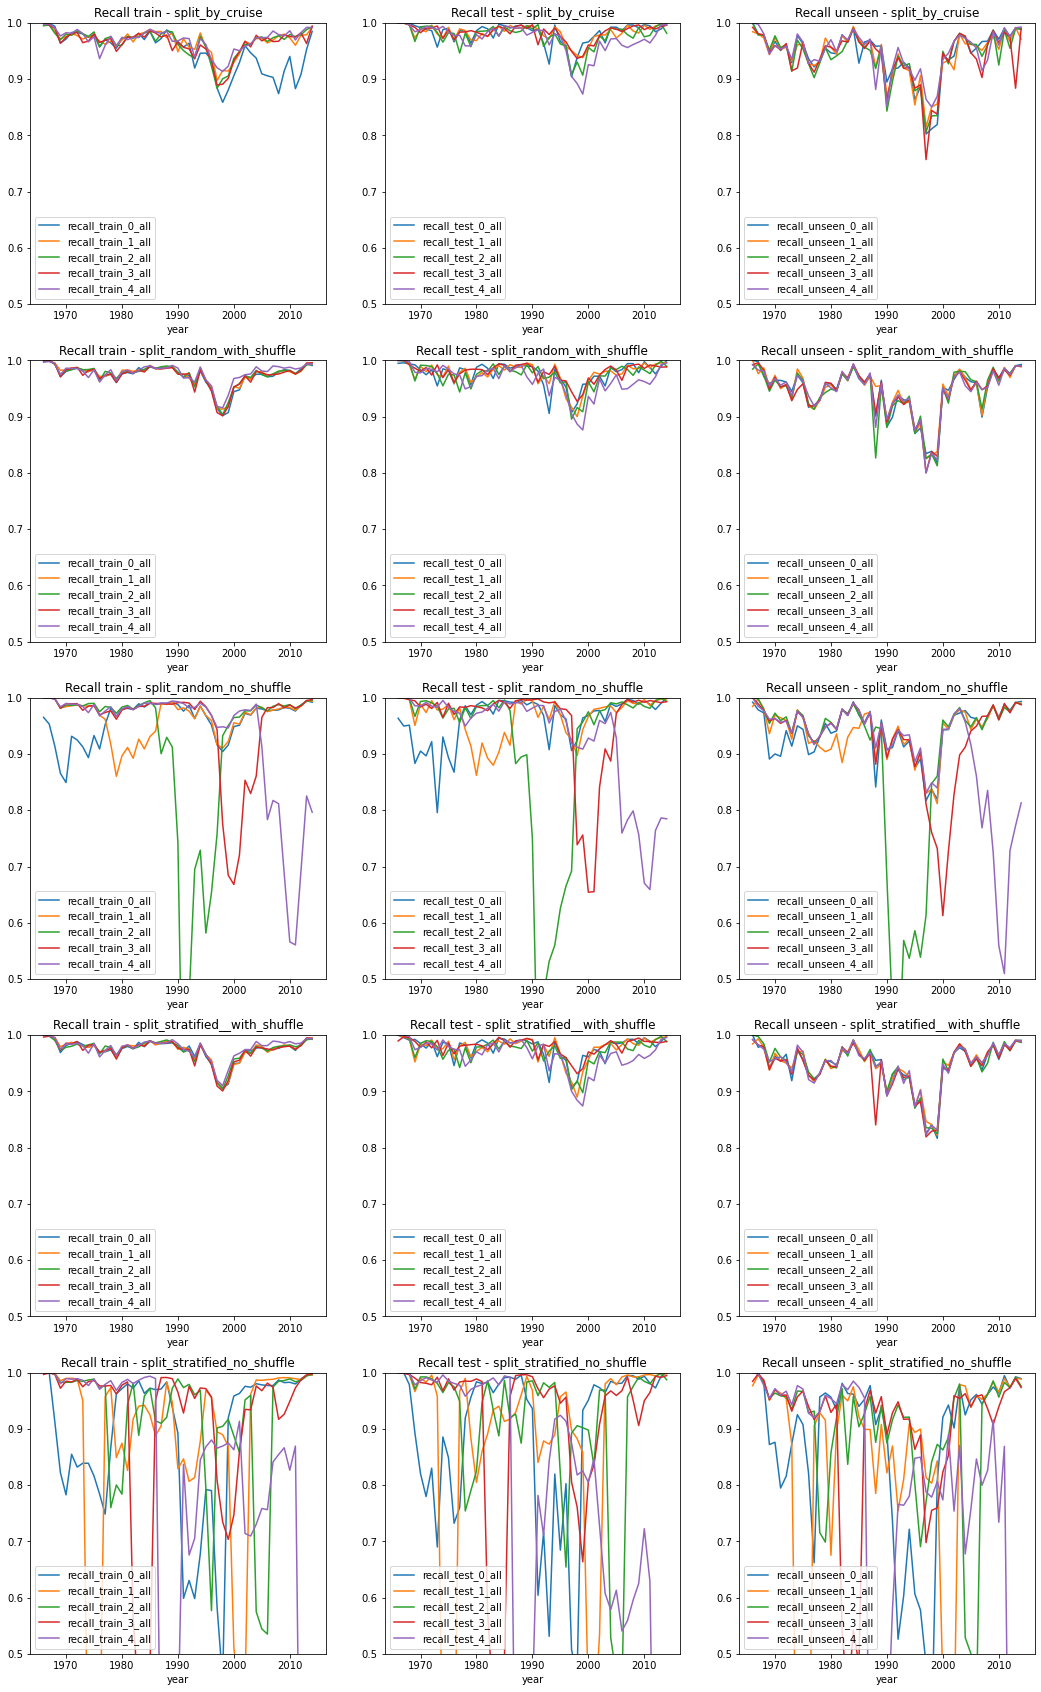

In [77]:
grid_rows = len(results_by_fold_subset.keys())
grid_cols = 3

fig_xbt_sens = matplotlib.pyplot.figure('xbt_sensitivity_results', figsize=(6*grid_cols, 6*grid_rows))
for grid_y, fold1 in enumerate(results_by_fold_subset.keys()):
    for grid_x, subset1 in enumerate(['train', 'test', 'unseen']):
        ax_xbt_sens = fig_xbt_sens.add_subplot(grid_rows, 
                                               grid_cols, 
                                               grid_y * grid_cols + grid_x + 1,
                                              title=f'Recall {subset1} - {fold1}',
                                              ylim=[0.5,1.0])
        _ = results_by_fold_subset[fold1][subset1].plot(ax=ax_xbt_sens,
                                                        x='year')


Average for each of the different fold types:

In [85]:
sensitivity_summary_df[sensitivity_summary_df.name.str.contains('unseen')].mean(axis=0)

recall_split_by_cruise                   0.938884
recall_split_random_with_shuffle         0.939088
recall_split_random_no_shuffle           0.918282
recall_split_stratified__with_shuffle    0.940172
recall_split_stratified_no_shuffle       0.858918
dtype: float64

From the plots and table above, we see how coosing the wrong sort of split can easily cause a dramatic degradation in accuracy. The biggest affect is caused by not shuffling the data before splitting.

Slightly surprisingly, after initial intuition suggested that splitting by cruise was giving much better results than random splitting, we can see that either the random or stratified splitting, so long as it is done properly, give similar or even slightly better results than the more complicated splitting by cruise.